<a href="https://colab.research.google.com/github/podo1skii/spbu_mtmodel/blob/master/bookings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install eli5

     |████████████████████████████████| 112kB 4.3MB/s 


In [2]:
# Setup

# common:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import folium

# for ML:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import eli5 # Feature importance evaluation



# set some display options:
sns.set(style="whitegrid")
pd.set_option("display.max_columns", 36)

# load data:
file_path = "hotel_bookings.csv"
full_data = pd.read_csv(file_path)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.



In [3]:
# A bit of data inspection and cleanup, I did most of the inspectin seperately
full_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
# check for missing values
full_data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [6]:
# Replace missing values:
# agent: If no agency is given, booking was most likely made without one.
# company: If none given, it was most likely private.
# rest schould be self-explanatory.
nan_replacements = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
full_data_cln = full_data.fillna(nan_replacements)

# "meal" contains values "Undefined", which is equal to SC.
full_data_cln["meal"].replace("Undefined", "SC", inplace=True)

# Some rows contain entreis with 0 adults, 0 children and 0 babies. 
# I'm dropping these entries with no guests.
zero_guests = list(full_data_cln.loc[full_data_cln["adults"]
                   + full_data_cln["children"]
                   + full_data_cln["babies"]==0].index)
full_data_cln.drop(full_data_cln.index[zero_guests], inplace=True)

## 1. EDA

In [7]:
# After cleaning, separate Resort and City hotel
# To know the acutal visitor numbers, only bookings that were not canceled are included. 
rh = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel") & (full_data_cln["is_canceled"] == 0)]
ch = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel") & (full_data_cln["is_canceled"] == 0)]

### Where do the guests come from?

In [8]:
# get number of acutal guests by country
country_data = pd.DataFrame(full_data_cln.loc[full_data_cln["is_canceled"] == 0]["country"].value_counts())
#country_data.index.name = "country"
country_data.rename(columns={"country": "Number of Guests"}, inplace=True)
total_guests = country_data["Number of Guests"].sum()
country_data["Guests in %"] = round(country_data["Number of Guests"] / total_guests * 100, 2)
country_data["country"] = country_data.index
#country_data.loc[country_data["Guests in %"] < 2, "country"] = "Other"

# pie plot
fig = px.pie(country_data,
             values="Number of Guests",
             names="country",
             title="Home country of guests",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

In [9]:
# show on map
guest_map = px.choropleth(country_data,
                    locations=country_data.index,
                    color=country_data["Guests in %"], 
                    hover_name=country_data.index, 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Home country of guests")
guest_map.show()

### How much do guests pay for a room per night?  
 

In [10]:
# Counting adults and children as paying guests only, not babies.
rh["adr_pp"] = rh["adr"] / (rh["adults"] + rh["children"])
ch["adr_pp"] = ch["adr"] / (ch["adults"] + ch["children"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
print("""From all non-cnceled bookings, across all room types and meals, the average prices are:
Resort hotel: {:.2f} € per night and person.
City hotel: {:.2f} € per night and person."""
      .format(rh["adr_pp"].mean(), ch["adr_pp"].mean()))

From all non-cnceled bookings, across all room types and meals, the average prices are:
Resort hotel: 47.49 € per night and person.
City hotel: 59.27 € per night and person.


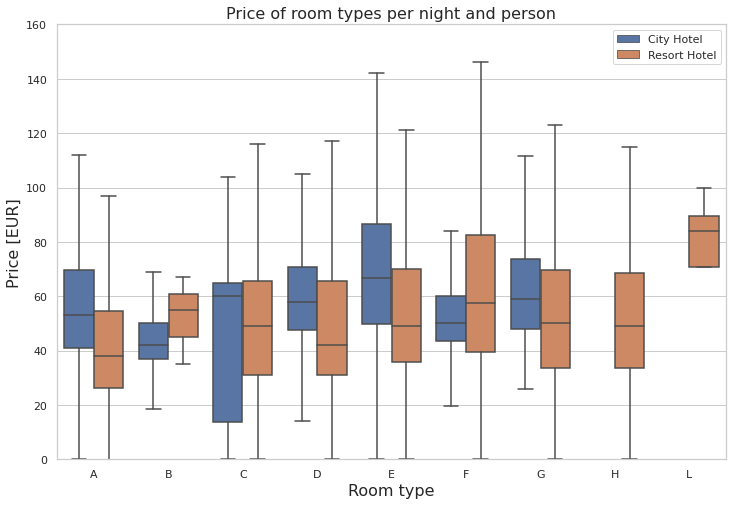

In [12]:
# normalize price per night (adr):
full_data_cln["adr_pp"] = full_data_cln["adr"] / (full_data_cln["adults"] + full_data_cln["children"])
full_data_guests = full_data_cln.loc[full_data_cln["is_canceled"] == 0] # only actual gusts
room_prices = full_data_guests[["hotel", "reserved_room_type", "adr_pp"]].sort_values("reserved_room_type")

# boxplot:
plt.figure(figsize=(12, 8))
sns.boxplot(x="reserved_room_type",
            y="adr_pp",
            hue="hotel",
            data=room_prices, 
            hue_order=["City Hotel", "Resort Hotel"],
            fliersize=0)
plt.title("Price of room types per night and person", fontsize=16)
plt.xlabel("Room type", fontsize=16)
plt.ylabel("Price [EUR]", fontsize=16)
plt.legend(loc="upper right")
plt.ylim(0, 160)
plt.show()

### How does the price per night vary over the year?  


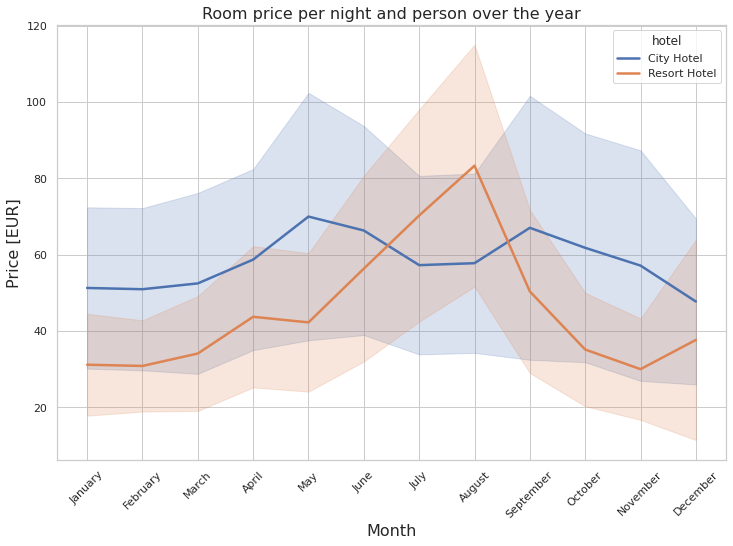

In [13]:
# grab data:
room_prices_mothly = full_data_guests[["hotel", "arrival_date_month", "adr_pp"]].sort_values("arrival_date_month")

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
room_prices_mothly["arrival_date_month"] = pd.Categorical(room_prices_mothly["arrival_date_month"], categories=ordered_months, ordered=True)

# barplot with standard deviation:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "arrival_date_month", y="adr_pp", hue="hotel", data=room_prices_mothly, 
            hue_order = ["City Hotel", "Resort Hotel"], ci="sd", size="hotel", sizes=(2.5, 2.5))
plt.title("Room price per night and person over the year", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Price [EUR]", fontsize=16)
plt.show()

### Which are the most busy month?

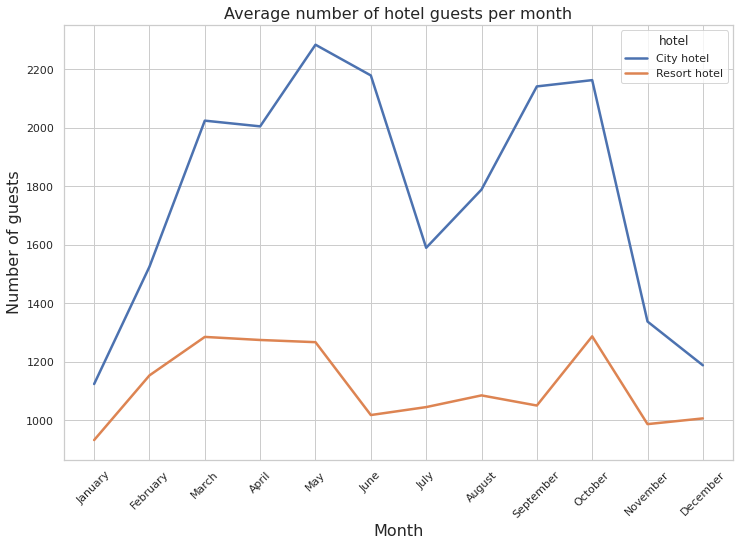

In [14]:
# Create a DateFrame with the relevant data:
resort_guests_monthly = rh.groupby("arrival_date_month")["hotel"].count()
city_guests_monthly = ch.groupby("arrival_date_month")["hotel"].count()

resort_guest_data = pd.DataFrame({"month": list(resort_guests_monthly.index),
                    "hotel": "Resort hotel", 
                    "guests": list(resort_guests_monthly.values)})

city_guest_data = pd.DataFrame({"month": list(city_guests_monthly.index),
                    "hotel": "City hotel", 
                    "guests": list(city_guests_monthly.values)})
full_guest_data = pd.concat([resort_guest_data,city_guest_data], ignore_index=True)

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_guest_data["month"] = pd.Categorical(full_guest_data["month"], categories=ordered_months, ordered=True)

# Dataset contains July and August date from 3 years, the other month from 2 years. Normalize data:
full_guest_data.loc[(full_guest_data["month"] == "July") | (full_guest_data["month"] == "August"),
                    "guests"] /= 3
full_guest_data.loc[~((full_guest_data["month"] == "July") | (full_guest_data["month"] == "August")),
                    "guests"] /= 2

#show figure:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "month", y="guests", hue="hotel", data=full_guest_data, 
             hue_order = ["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Average number of hotel guests per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of guests", fontsize=16)
plt.show()

### How long do people stay at the hotels?

In [15]:
# Create a DateFrame with the relevant data:
rh["total_nights"] = rh["stays_in_weekend_nights"] + rh["stays_in_week_nights"]
ch["total_nights"] = ch["stays_in_weekend_nights"] + ch["stays_in_week_nights"]

num_nights_res = list(rh["total_nights"].value_counts().index)
num_bookings_res = list(rh["total_nights"].value_counts())
rel_bookings_res = rh["total_nights"].value_counts() / sum(num_bookings_res) * 100 # convert to percent

num_nights_cty = list(ch["total_nights"].value_counts().index)
num_bookings_cty = list(ch["total_nights"].value_counts())
rel_bookings_cty = ch["total_nights"].value_counts() / sum(num_bookings_cty) * 100 # convert to percent

res_nights = pd.DataFrame({"hotel": "Resort hotel",
                           "num_nights": num_nights_res,
                           "rel_num_bookings": rel_bookings_res})

cty_nights = pd.DataFrame({"hotel": "City hotel",
                           "num_nights": num_nights_cty,
                           "rel_num_bookings": rel_bookings_cty})

nights_data = pd.concat([res_nights, cty_nights], ignore_index=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



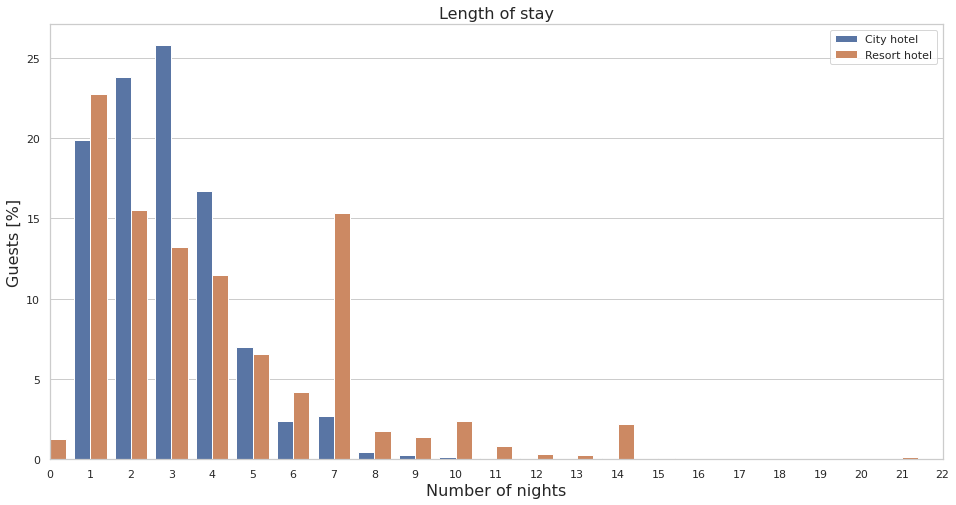

In [16]:
#show figure:
plt.figure(figsize=(16, 8))
sns.barplot(x = "num_nights", y = "rel_num_bookings", hue="hotel", data=nights_data,
            hue_order = ["City hotel", "Resort hotel"])
plt.title("Length of stay", fontsize=16)
plt.xlabel("Number of nights", fontsize=16)
plt.ylabel("Guests [%]", fontsize=16)
plt.legend(loc="upper right")
plt.xlim(0,22)
plt.show()

In [17]:
avg_nights_res = sum(list((res_nights["num_nights"] * (res_nights["rel_num_bookings"]/100)).values))
avg_nights_cty = sum(list((cty_nights["num_nights"] * (cty_nights["rel_num_bookings"]/100)).values))
print(f"On average, guests of the City hotel stay {avg_nights_cty:.2f} nights, and {cty_nights['num_nights'].max()} at maximum.")
print(f"On average, guests of the Resort hotel stay {avg_nights_res:.2f} nights, and {res_nights['num_nights'].max()} at maximum.")

On average, guests of the City hotel stay 2.92 nights, and 48 at maximum.
On average, guests of the Resort hotel stay 4.14 nights, and 69 at maximum.


### How many bookings were canceled?

In [23]:
# absolute cancelations:
total_cancelations = full_data_cln["is_canceled"].sum()
rh_cancelations = full_data_cln.loc[full_data_cln["hotel"] == "Resort Hotel"]["is_canceled"].sum()
ch_cancelations = full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"]["is_canceled"].sum()

# as percent:
rel_cancel = total_cancelations / full_data_cln.shape[0] * 100
rh_rel_cancel = rh_cancelations / full_data_cln.loc[full_data_cln["hotel"] == "Resort Hotel"].shape[0] * 100
ch_rel_cancel = ch_cancelations / full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"].shape[0] * 100

print(f"Total bookings canceled: {total_cancelations:,} ({rel_cancel:.0f} %)")
print(f"Resort hotel bookings canceled: {rh_cancelations:,} ({rh_rel_cancel:.0f} %)")
print(f"City hotel bookings canceled: {ch_cancelations:,} ({ch_rel_cancel:.0f} %)")

Total bookings canceled: 44,199 (37 %)
Resort hotel bookings canceled: 11,120 (28 %)
City hotel bookings canceled: 33,079 (42 %)


### Which month have the highest number of cancelations?

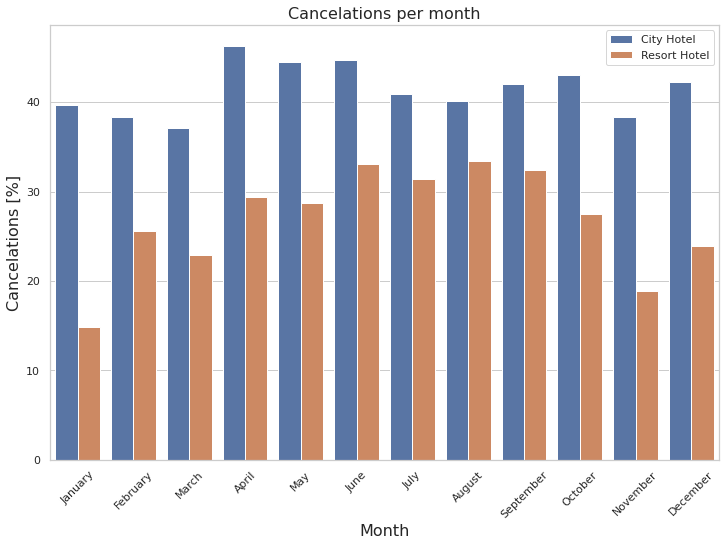

In [24]:
# Create a DateFrame with the relevant data:
res_book_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
res_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

cty_book_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
cty_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(res_book_per_month.index),
                                "Bookings": list(res_book_per_month.values),
                                "Cancelations": list(res_cancel_per_month.values)})
cty_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(cty_book_per_month.index),
                                "Bookings": list(cty_book_per_month.values),
                                "Cancelations": list(cty_cancel_per_month.values)})

full_cancel_data = pd.concat([res_cancel_data, cty_cancel_data], ignore_index=True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"] / full_cancel_data["Bookings"] * 100

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)

# show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x = "Month", y = "cancel_percent" , hue="Hotel",
            hue_order = ["City Hotel", "Resort Hotel"], data=full_cancel_data)
plt.title("Cancelations per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.legend(loc="upper right")
plt.show()

For the City hotel the relative number of cancelations is around 40 % throughout the year.  
For the Resort hotel it is highest in the summer and lowest during the winter. 

## 2. Predict cancelations  

In [25]:
#Which numerical features are most important?
cancel_corr = full_data.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
agent                             0.083114
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

In [26]:
full_data.groupby("is_canceled")["reservation_status"].value_counts()

is_canceled  reservation_status
0            Check-Out             75166
1            Canceled              43017
             No-Show                1207
Name: reservation_status, dtype: int64

### Comparing different base models:

In [27]:
# manually choose columns to include
# some columns are excluded to make the model more general and to prevent leakage
# (arrival_date_year, assigned_room_type, booking_changes, reservation_status, country,
# days_in_waiting_list)
# including the country would increase accuracy, but it may also make the model less general

num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# Separate features and predicted value
features = num_features + cat_features
X = full_data.drop(["is_canceled"], axis=1)[features]
y = full_data["is_canceled"]

# preprocess numerical feats:
# for most num cols, except the dates, 0 is the most logical choice as fill value
# and here no dates are missing.
num_transformer = SimpleImputer(strategy="constant")

# Preprocessing for categorical features:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

In [28]:
# define models to test:
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]

# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in base_models:
    # pack preprocessing of data and the model in a pipeline:
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    # get cross validation score for each model:
    cv_results = cross_val_score(model_steps, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    # output:
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")
    
    #pipeline.fit(X_train, y_train)
    #preds = pipeline.predict(X_valid)
    #score = accuracy_score(y_valid, preds)
    #print(f"{name} accuracy_score: {round(score, 4)}")
    

DT_model cross validation accuarcy score: 0.8246 +/- 0.0016 (std) min: 0.8221, max: 0.8263
RF_model cross validation accuarcy score: 0.8664 +/- 0.0012 (std) min: 0.8646, max: 0.8676
LR_model cross validation accuarcy score: 0.7937 +/- 0.0012 (std) min: 0.792, max: 0.7952
XGB_model cross validation accuarcy score: 0.8165 +/- 0.0016 (std) min: 0.8139, max: 0.8181


In [29]:
# Enhanced RF model with the best parameters I found:
rf_model_enh = RandomForestClassifier(n_estimators=160,
                               max_features=0.4,
                               min_samples_split=2,
                               n_jobs=-1,
                               random_state=0)

split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model_enh)])
cv_results = cross_val_score(model_pipe, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
# output:
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"Enhanced RF model cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Enhanced RF model cross validation accuarcy score: 0.8681 +/- 0.0006 (std) min: 0.8673, max: 0.869


# 3. Evaluate Feature importance

In [31]:
# fit model(pipeline) so values can be accessed:
model_pipe.fit(X,y)

# Names of all (encoded) features are needed.
# Get names of columns from One Hot Encoding:
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names(input_features=cat_features))

# Add num_features for full list.
# Order must be as in definition of X, where num_features are first: 
feat_imp_list = num_features + onehot_columns

# show 10 most important features, provide names of features:
feat_imp_df = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names=feat_imp_list)
feat_imp_df.head(10)

,feature,weight,std
0,lead_time,0.145140,0.015235
1,deposit_type_Non Refund,0.140641,0.108007
2,adr,0.096222,0.003412
3,deposit_type_No Deposit,0.079059,0.106235
4,arrival_date_day_of_month,0.069410,0.002033
5,arrival_date_week_number,0.053763,0.001999
6,total_of_special_requests,0.050567,0.013314
7,agent,0.043060,0.006392
8,stays_in_week_nights,0.041588,0.002291
9,previous_cancellations,0.038626,0.013459
